In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/drive/MyDrive/ML4_AI/data/open/train.csv')
train.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [4]:
train.head(20)

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4
5,TRAIN_0005,./train/TRAIN_0005.wav,3
6,TRAIN_0006,./train/TRAIN_0006.wav,0
7,TRAIN_0007,./train/TRAIN_0007.wav,0
8,TRAIN_0008,./train/TRAIN_0008.wav,2
9,TRAIN_0009,./train/TRAIN_0009.wav,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [6]:
train.shape

(5001, 3)

In [7]:
train.label.groupby(train.label).count()

,label
label,
0,867
1,848
2,859
3,852
4,722
5,853


label : 감정의 종류
0: angry
1: fear
2: sad
3: disgust
4: neutral
5: happy

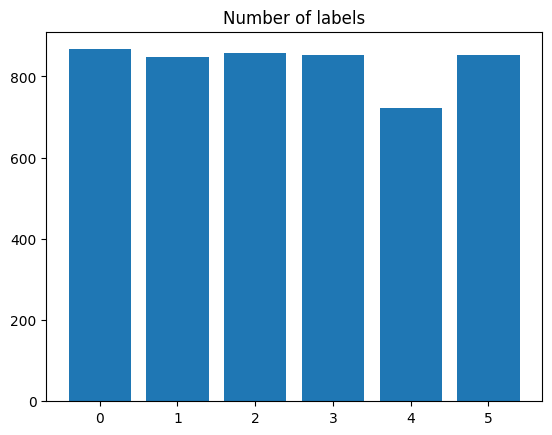

In [8]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

100%|██████████| 5001/5001 [18:51<00:00,  4.42it/s]


<Axes: title={'center': 'Length of audio'}, ylabel='Density'>

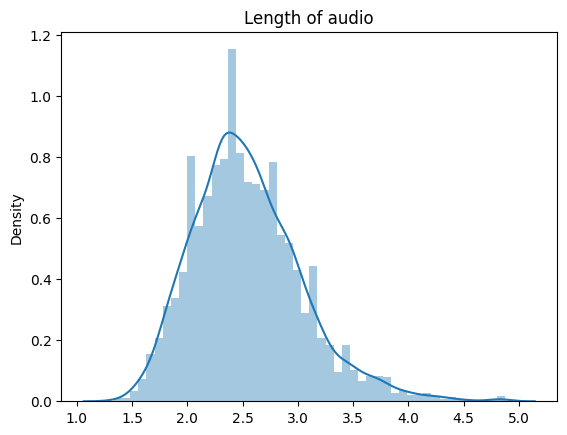

In [9]:
from tqdm import tqdm

len_list = []

for i in tqdm(train.id):
    y, s = librosa.load('/content/drive/MyDrive/ML4_AI/data/open/train/' + i + '.wav')
    len_list.append(len(y)/s)
# len_list로 정규분포 확인
plt.title("Length of audio")
sns.distplot(len_list)

오디오 파형을 시각화

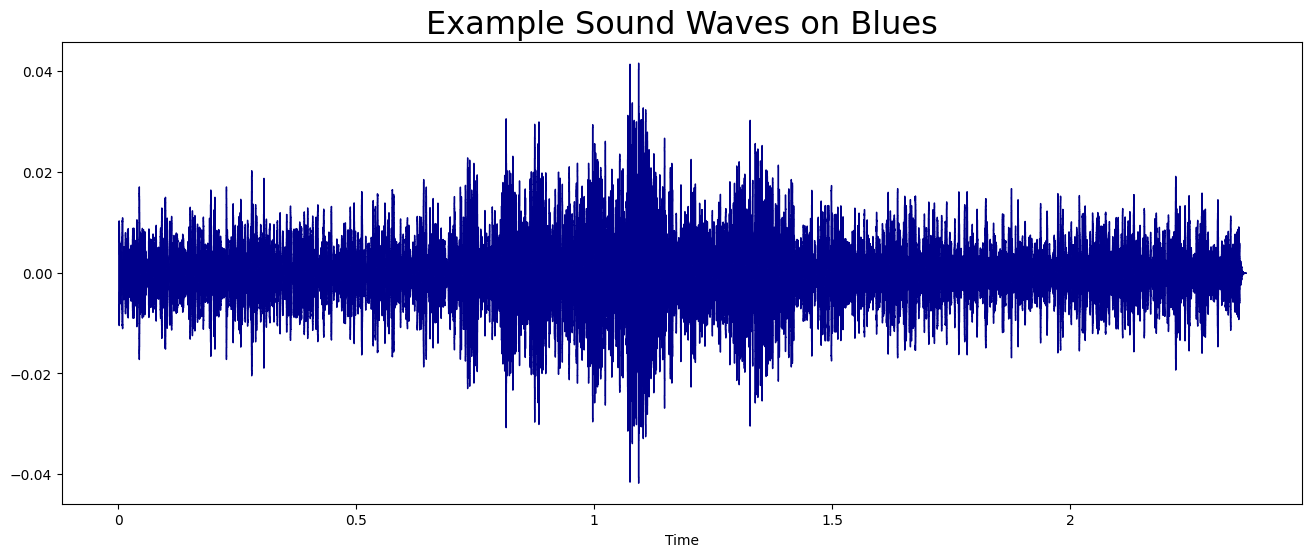

In [10]:
y,s = librosa.load('/content/drive/MyDrive/ML4_AI/data/open/train/TRAIN_0000.wav')

audio, _ = librosa.effects.trim(y) # 침묵이 제거된 오디오 신호.두 번째 반환값은 트리밍된 영역의 인덱스로, 필요 없으므로 _로 무시

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

푸리에 변환

푸리에 변환(Fourier transform, FT)은 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환\
특징 추출을 위해

In [11]:
fft = 2048 # 2048개 샘플의 구간을 변환 단위
hl = 512   # STFT에서 각 프레임 간의 간격(샘플 수)을 설정. 512 샘플 간격으로 슬라이딩하면서 변환을 수행

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl)) # librosa의 STFT 함수를 통해 오디오 신호의 주파수-시간 정보를 추출

# audio: 변환할 오디오 신호입니다.
# n_fft=fft: 각 프레임에서 푸리에 변환을 수행할 FFT 윈도우 크기를 설정합니다.
# hop_length=hl: 프레임 간의 간격을 설정해, 프레임들이 중첩되도록 합니다.
print(np.shape(stft)) # STFT 결과의 배열 크기를 출력

(1025, 103)


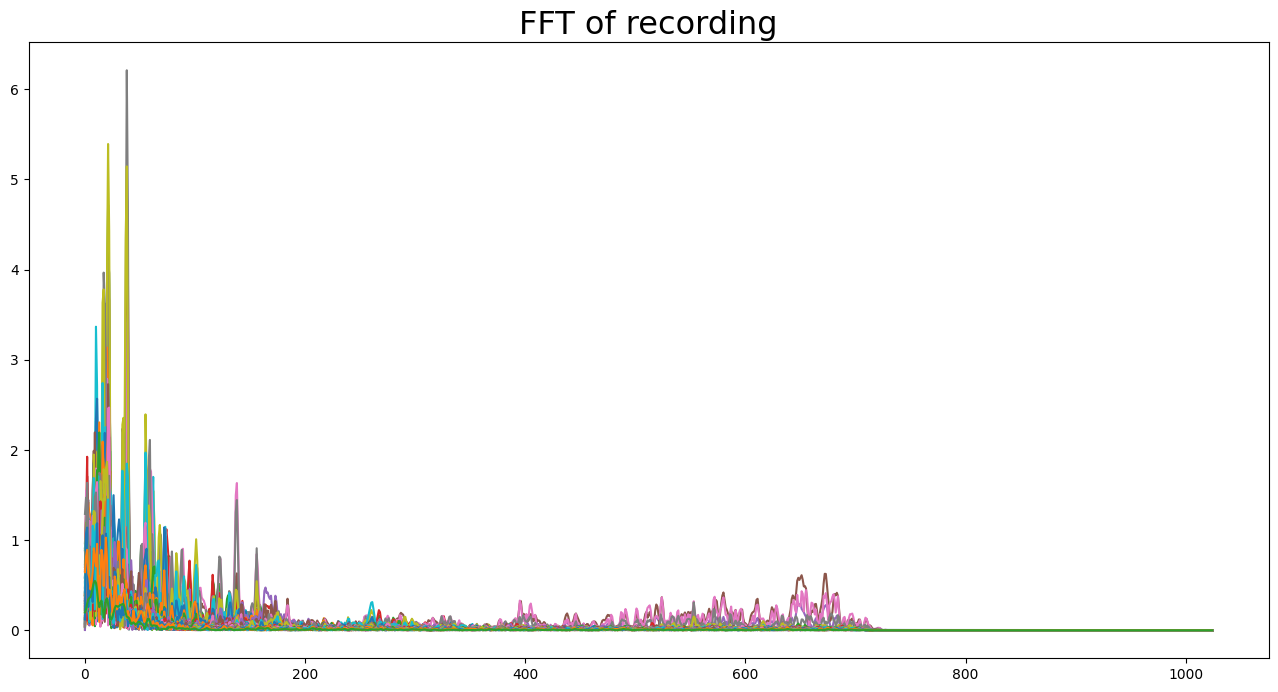

In [12]:
# 0~200 주파수 대역에 데이터가 몰려있음
plt.figure(figsize = (16, 8))
plt.title("FFT of recording", fontsize = 23);
plt.plot(stft);

멜 스펙트로그램(Mel Spectrogram)은 오디오 신호의 주파수 정보를 멜(Mel) 스케일로 변환하여 시각화한 스펙트로그램입니다. 이는 사람의 청각 특성을 반영해, 낮은 주파수에서는 세밀하게, 높은 주파수에서는 덜 세밀하게 분석

In [13]:
def Mel_s(num = 0, frame_length = 0.025, frame_stride = 0.010):
    sample = os.listdir('/content/drive/MyDrive/ML4_AI/data/open/train')
    temp = train[train.label == num].id
    file_name = temp[temp.index[0]]

    file = '/content/drive/MyDrive/ML4_AI/data/open/train/' + file_name + '.wav'
    data,sample_rate = librosa.load(file, sr = 16000) # 샘플링 레이트를 16,000Hz로 설정해 로드

    input_nfft = int(round(sample_rate*frame_length)) #  STFT의 FFT 윈도우 크기를 샘플 수 단위로 계산합니다. 프레임 길이 0.025초에 해당하는 샘플 수
    input_stride = int(round(sample_rate*frame_stride)) # 프레임 간 간격을 샘플 수 단위로 계산합니다. 프레임 간격 0.010초에 해당하는 샘플 수

    S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)

    # librosa.feature.melspectrogram() 함수를 사용해 멜 스펙트로그램을 계산합니다.
    # y=data: 오디오 데이터를 입력으로 사용합니다.
    # n_mels=100: 멜 필터의 개수를 100으로 설정합니다.
    # n_fft=input_nfft: FFT 윈도우 크기를 설정합니다.
    # hop_length=input_stride: 프레임 간 간격을 설정합니다.
    # S는 시간과 주파수 영역에서의 멜 스펙트로그램을 포함하는 배열입니다.

    print("Wav length: {}, Mel_S shape:{}".format(len(data)/sample_rate, np.shape(S))) # 오디오 길이(초)와 멜 스펙트로그램의 크기를 출력

    S_dB  = librosa.power_to_db(S, ref=np.max) # 함수를 통해 스펙트로그램의 파워 값을 데시벨 단위로 변환
    fig = plt.figure(figsize = (14,5))
    librosa.display.specshow(S_dB,
                             sr=sample_rate,
                             hop_length=input_stride,
                             x_axis='time',
                             y_axis='log')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel spectrogram of audio label {num}")
    plt.show()



Wav length: 2.06875, Mel_S shape:(100, 207)


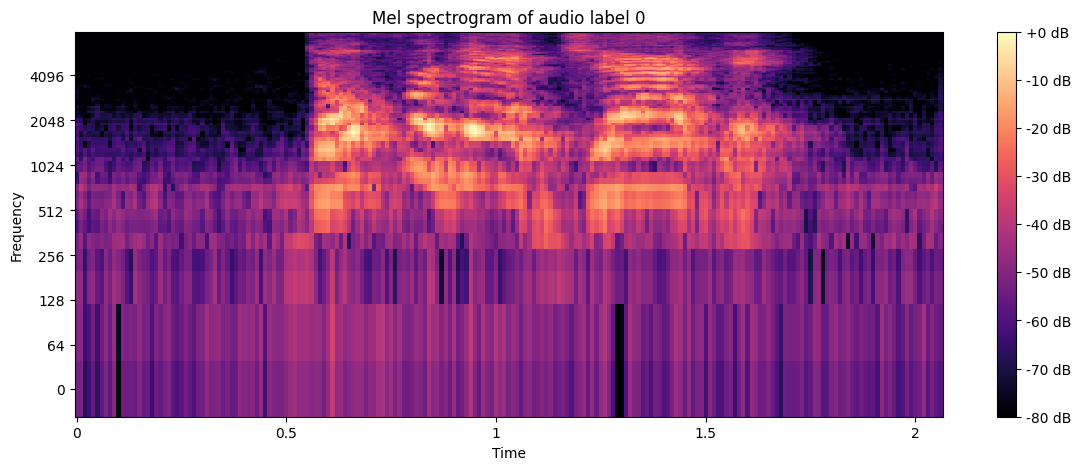

Wav length: 2.369, Mel_S shape:(100, 237)


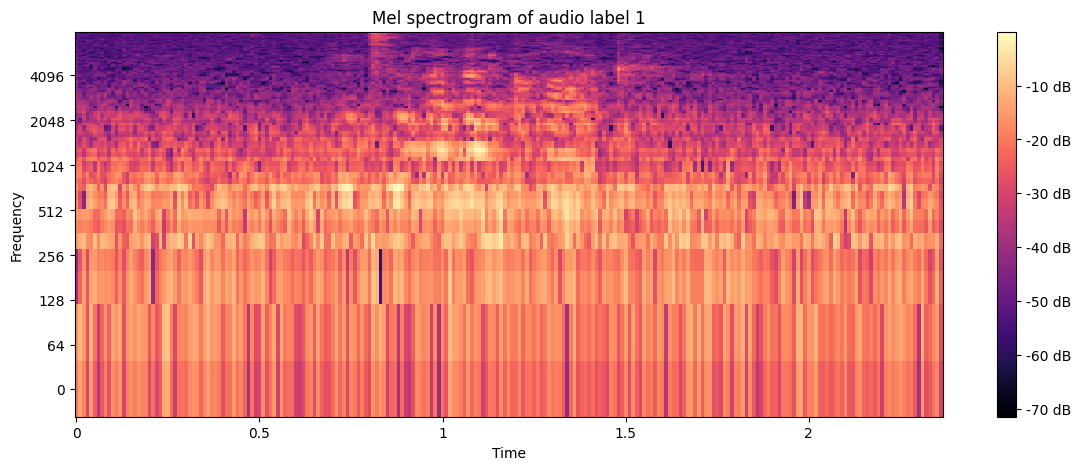

Wav length: 2.602625, Mel_S shape:(100, 261)


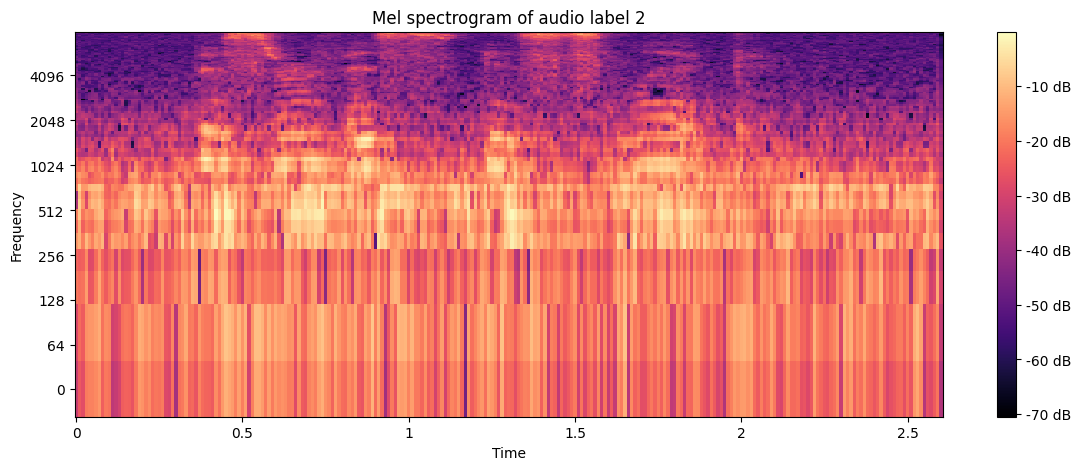

Wav length: 2.5025, Mel_S shape:(100, 251)


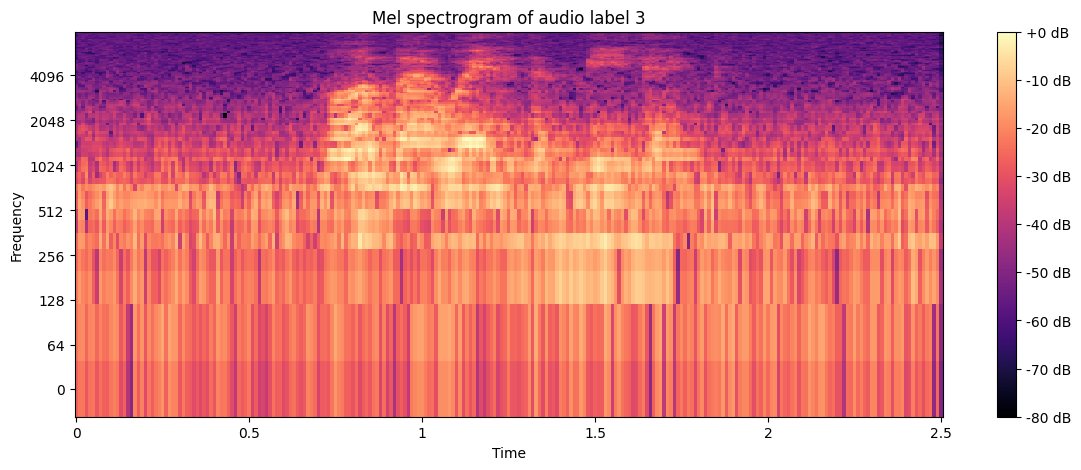

Wav length: 2.902875, Mel_S shape:(100, 291)


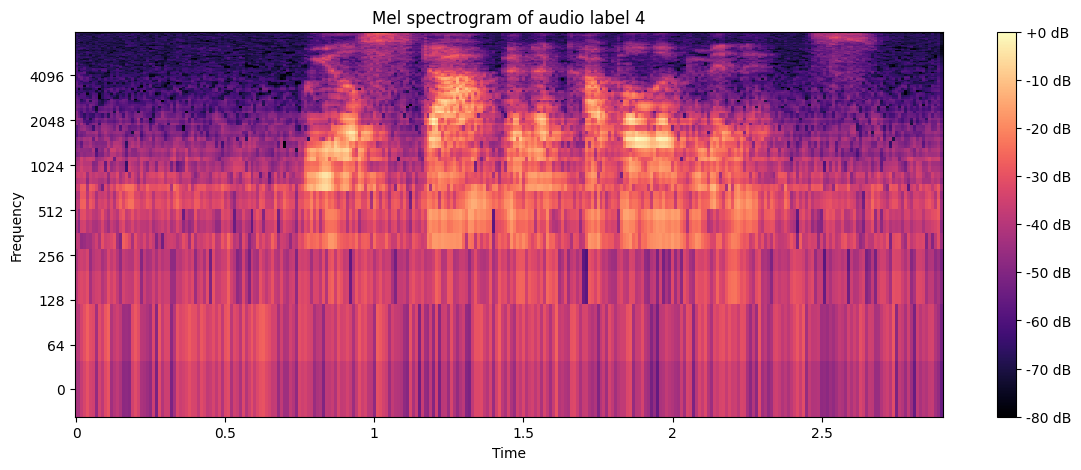

Wav length: 2.3023125, Mel_S shape:(100, 231)


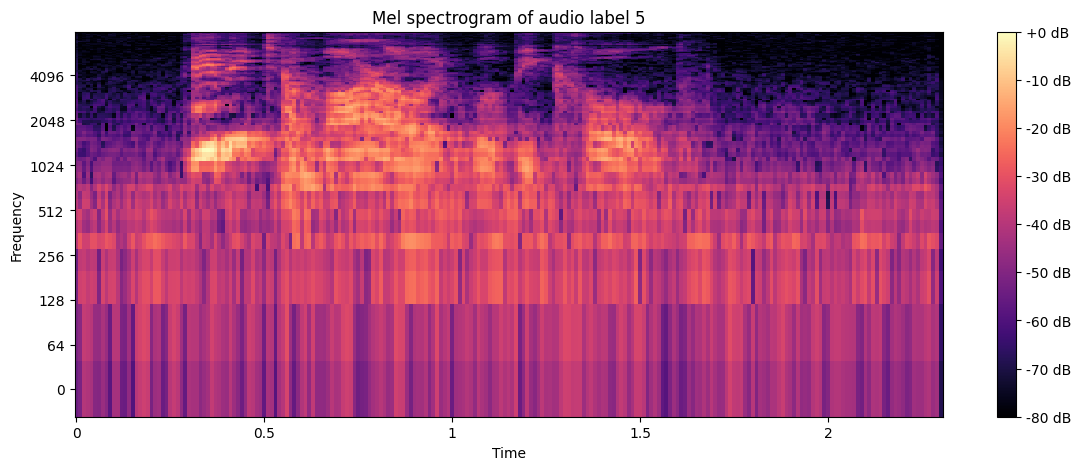

In [14]:
for i in range(0,6):
    Mel_s(i)

 MFCC는 음성 신호에서 멜 스케일로 변환된 스펙트럼을 다시 푸리에 변환한 후, 신호의 주요 특성(음성의 텍스처 등)을 추출하는 데 사용

Label 0 - Mean of MFCCs: [-3.9131439e+02  7.2218552e+01  1.6573187e+01  2.6692902e+01
  2.2020564e+00 -1.6305613e+01 -8.9901314e+00 -7.9757652e+00
 -5.5250115e+00 -1.6466073e+00 -3.3304932e+00 -1.3323241e-01
 -2.1972337e+00]
Shape of MFCCs: (13, 207)


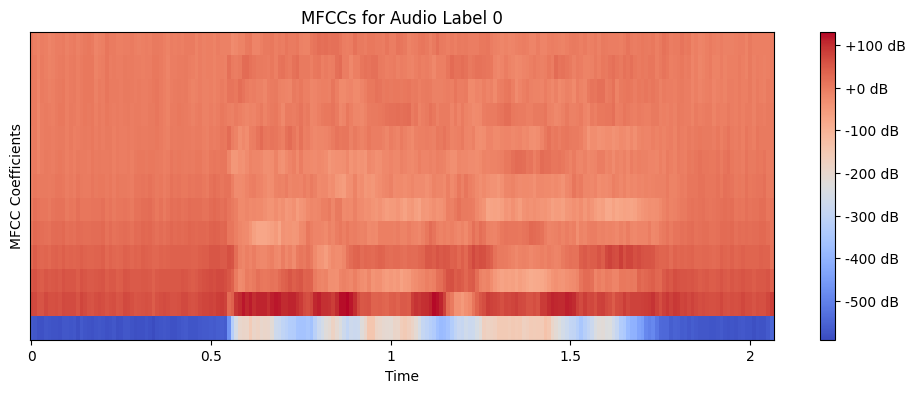

In [16]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc_by_label(num=0, sr=16000, n_mfcc=13, frame_length=0.025, frame_stride=0.010):
    """
    주어진 레이블(num)에 해당하는 오디오 파일에서 MFCC를 추출하고 시각화합니다.

    Parameters:
    - num (int): 오디오 파일의 레이블 값
    - sr (int): 샘플링 레이트 (기본값: 16000)
    - n_mfcc (int): 추출할 MFCC 계수의 개수 (기본값: 13)
    - frame_length (float): 프레임 길이 (초 단위, 기본값: 0.025)
    - frame_stride (float): 프레임 간 간격 (초 단위, 기본값: 0.010)
    """
    # 레이블에 따른 파일 목록에서 오디오 파일 선택
    sample_path = '/content/drive/MyDrive/ML4_AI/data/open/train'
    sample_files = os.listdir(sample_path)
    label_files = train[train.label == num].id
    file_name = label_files.iloc[0]  # 첫 번째 파일 선택

    file_path = os.path.join(sample_path, file_name + '.wav')

    # 오디오 파일 로드
    data, sample_rate = librosa.load(file_path, sr=sr)

    # FFT 윈도우 크기 및 프레임 간 간격 설정
    n_fft = int(round(sample_rate * frame_length))
    hop_length = int(round(sample_rate * frame_stride))

    # MFCC 추출
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC의 평균과 형태 출력
    print(f"Label {num} - Mean of MFCCs:", np.mean(mfccs, axis=1))
    print("Shape of MFCCs:", mfccs.shape)

    # MFCC 시각화
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCCs for Audio Label {num}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()

# 사용 예시 (레이블 값에 따라 MFCC를 시각화)
plot_mfcc_by_label(num=0)


가로축(시간):

가로축은 시간 흐름을 나타내며, 오디오의 시작부터 끝까지의 변화를 보여줍니다.
소리가 특정 시간에 어떤 특성을 가지는지 확인할 수 있습니다. 예를 들어, 음소가 바뀌는 순간이나 특정 음이 강조되는 시점이 어디인지 파악할 수 있습니다.
세로축(MFCC 계수):

세로축은 MFCC 계수로, 각각의 계수는 특정 주파수 대역에서 음성의 음색이나 특징을 나타냅니다.
MFCC 계수는 보통 13개에서 40개 정도로, 낮은 계수들은 주로 음성의 큰 구조를 표현하고, 높은 계수들은 더 세밀한 부분을 나타냅니다.
색상(데시벨 단위의 값):

색상은 데시벨(dB)로 표시된 MFCC 값의 크기를 나타냅니다. 색이 밝을수록 더 강한 신호 에너지를 의미하고, 어두운 색은 약한 에너지를 의미합니다.
특정 시간이거나 특정 주파수 대역에서 강한 에너지가 있다면, 해당 주파수 대역이 강조되었음을 의미합니다. 이는 음성의 성조나 강세, 발화의 뚜렷한 부분 등을 파악할 때 도움이 됩니다.
패턴 인식:

MFCC는 음성의 특성을 잘 반영하므로, 특정 패턴이 반복되는지 또는 비슷한 레이블에서 유사한 패턴이 나타나는지를 관찰할 수 있습니다.
예를 들어, 같은 레이블의 오디오에서 유사한 MFCC 패턴이 나타난다면, 해당 패턴이 레이블의 고유한 특징일 가능성이 큽니다.
레벨 비교:

다양한 레이블의 MFCC 시각화를 통해 각 레이블 간의 음성 특성 차이를 비교할 수 있습니다.
예를 들어, num=0과 num=1의 MFCC에서 특정 시간이나 주파수 대역에서 차이가 난다면, 이는 두 레이블이 다른 음성 특징을 가지고 있음을 암시합니다.

Label 0 - Mean of MFCCs: [-3.9131439e+02  7.2218552e+01  1.6573187e+01  2.6692902e+01
  2.2020564e+00 -1.6305613e+01 -8.9901314e+00 -7.9757652e+00
 -5.5250115e+00 -1.6466073e+00 -3.3304932e+00 -1.3323241e-01
 -2.1972337e+00]
Shape of MFCCs: (13, 207)


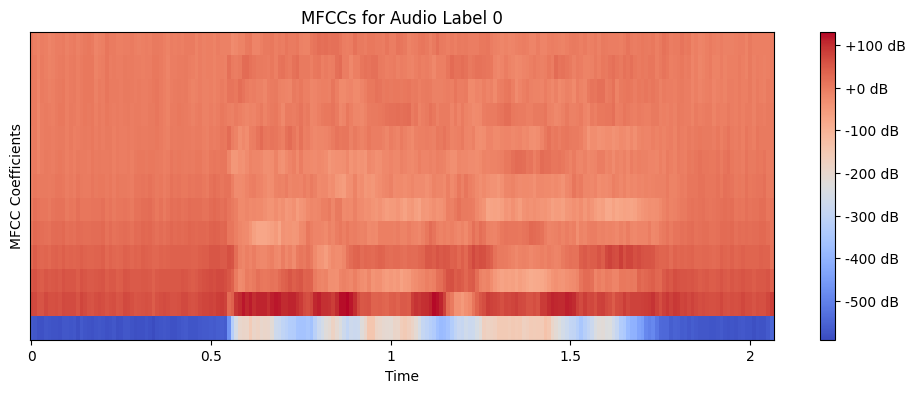

Label 1 - Mean of MFCCs: [-590.4521     107.0609      48.521725    23.741062    14.756869
    4.614577     1.1521956   -0.6752464    2.3870564    3.1260836
   -1.7409872   -3.6472976   -1.8499374]
Shape of MFCCs: (13, 237)


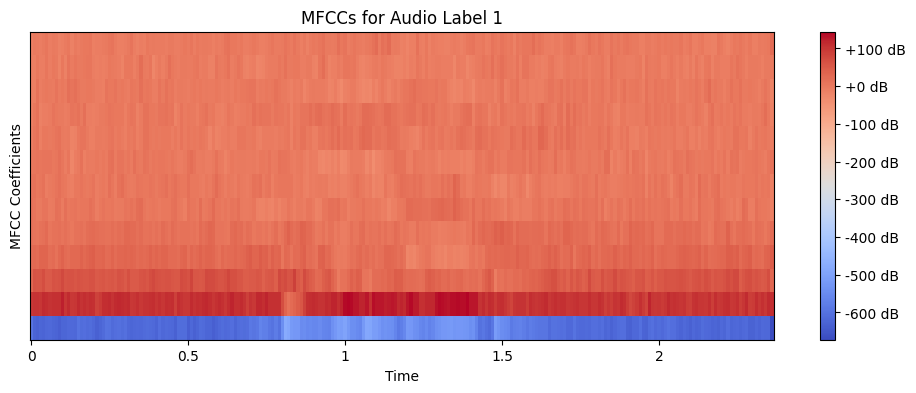

Label 2 - Mean of MFCCs: [-576.2228       82.14528      57.065956     32.20687      21.596748
    0.96501577    2.164433     -3.453978     -1.3453709    -0.8794565
   -6.4912186    -3.8397465    -2.731564  ]
Shape of MFCCs: (13, 261)


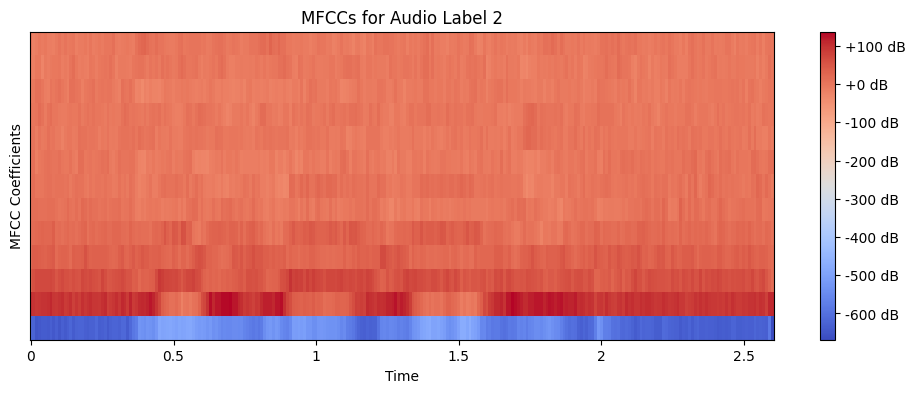

Label 3 - Mean of MFCCs: [-5.6903638e+02  1.1558200e+02  4.6836372e+01  2.7762976e+01
  1.1852325e+01 -1.4611151e+00  3.0552188e-01 -2.8604174e+00
 -3.6237049e+00 -2.9970734e+00 -1.5661192e+00 -1.5129576e+00
 -3.3483412e+00]
Shape of MFCCs: (13, 251)


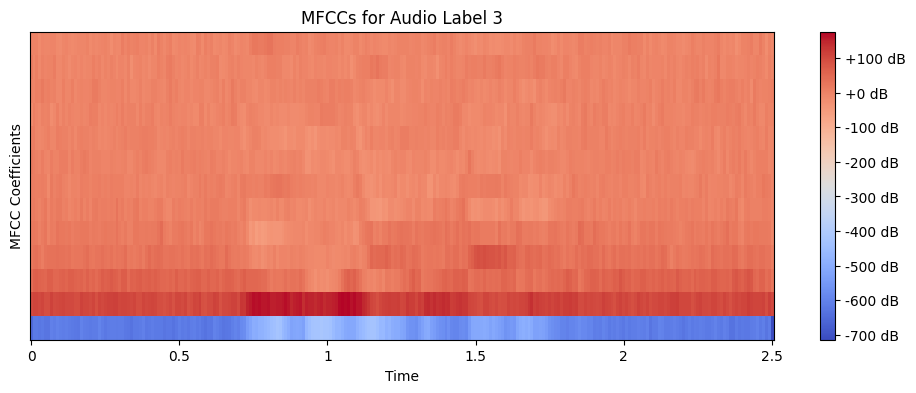

Label 4 - Mean of MFCCs: [-5.2173328e+02  9.6729698e+01  4.2543736e+01  2.0776449e+01
  1.9181991e+00  1.7353490e-01 -3.0675197e+00 -1.0498793e+01
 -1.8865174e+00 -2.5817201e+00 -2.7067518e+00 -2.2341583e+00
 -1.9763004e+00]
Shape of MFCCs: (13, 291)


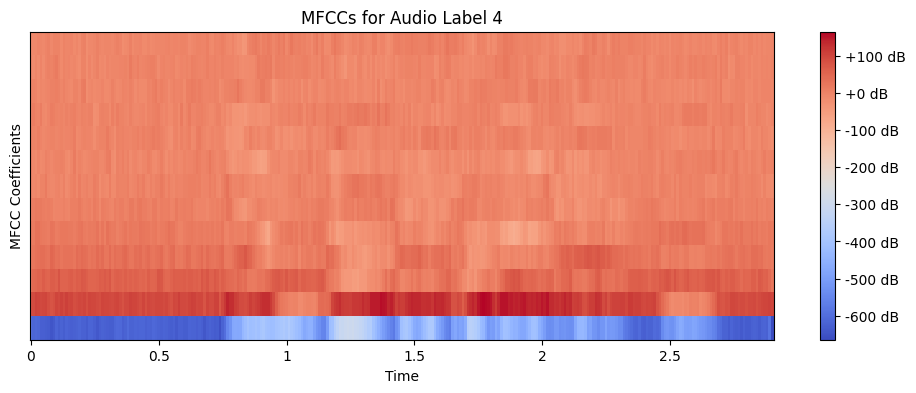

Label 5 - Mean of MFCCs: [-5.5887329e+02  1.1758731e+02  4.1919819e+01  2.6958025e+01
  2.2717285e-01 -1.6665165e+00  2.7719426e+00 -7.9513683e+00
 -2.9426053e+00 -4.5320272e+00 -6.3378992e+00 -2.3701584e+00
 -5.7505739e-01]
Shape of MFCCs: (13, 231)


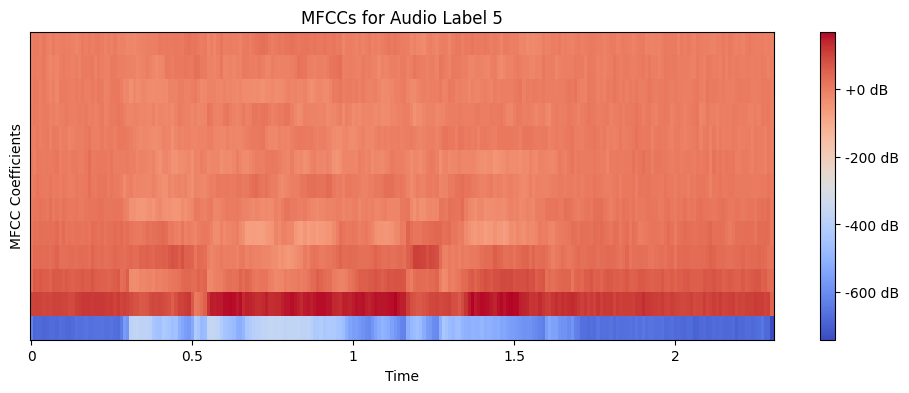

In [17]:
# 레이블 0부터 5까지 각 레이블의 MFCC 시각화
for label in range(6):  # 0, 1, 2, 3, 4, 5
    plot_mfcc_by_label(num=label)


이후 과정
머신러닝 모델에 사용할 수 있도록 2D 배열을 벡터화



Wav2Vec 2.0는 Facebook AI Research에서 개발한 음성 인식 모델로, 소량의 라벨이 있는 데이터로도 높은 성능의 음성 인식이 가능하도록 설계되었습니다. 이 모델은 음성 신호의 특징을 잘 추출해주는 특징 추출기와 학습 기법으로 주목받고 있습니다. Wav2Vec 2.0의 작동 방식은 크게 다음 세 단계로 나눌 수 있습니다:

1. 특징 추출기 (Feature Extractor)
CNN 기반 특징 추출기: 모델의 첫 부분은 Convolutional Neural Network(CNN)로 구성되어 있습니다. 이 부분은 오디오 신호에서 고수준의 특징을 추출하는 역할을 합니다. 이 CNN은 원본 오디오 데이터를 고차원 표현으로 변환해주며, 이를 통해 Wav2Vec 2.0은 오디오의 세밀한 주파수 정보를 잘 포착합니다.
CNN에서 추출된 특징은 모델이 다음 단계에서 유용하게 활용할 수 있는, 길이가 줄어든 잠재 표현(latent representation)으로 변환됩니다.
2. 변환기 인코더 (Transformer Encoder)
Transformer 구조: Wav2Vec 2.0의 핵심은 Transformer 인코더입니다. 이 인코더는 특징 추출기에서 생성된 잠재 표현을 입력으로 받아, 이들 간의 시간적 상관관계를 학습합니다. Transformer 구조는 음성 데이터에서 중요한 패턴을 학습하는 데 매우 효과적입니다.
Masking 기법: Wav2Vec 2.0은 일부 시퀀스를 마스킹(masking)하는 방식으로 학습하는데, 이 과정에서 마스킹된 부분을 예측하도록 학습됩니다. 이를 통해 모델은 맥락에 따라 음성의 일부를 예측하는 능력을 가지게 되며, 결과적으로 언어의 맥락적 특성을 학습할 수 있게 됩니다.
3. 사전 학습 및 미세 조정 (Pretraining and Fine-tuning)
Self-Supervised Pretraining: Wav2Vec 2.0은 대규모 비지도 학습으로 사전 학습됩니다. 이 모델은 라벨이 없는 대규모 음성 데이터에서 마스크된 부분을 예측하는 방식으로 학습하며, 이 과정을 통해 모델은 음성의 일반적인 패턴과 언어 특성을 이해하게 됩니다.
Supervised Fine-tuning: 사전 학습이 완료된 후, 소량의 라벨이 있는 데이터로 모델을 미세 조정(fine-tuning)할 수 있습니다. 이를 통해 Wav2Vec 2.0은 특정 음성 인식 태스크에 맞게 조정됩니다. 학습된 모델은 매우 적은 양의 라벨 데이터를 사용해도 높은 성능을 발휘할 수 있습니다.
Wav2Vec 2.0의 장점
효율성: 대규모 비라벨 음성 데이터를 이용해 사전 학습이 가능하므로, 적은 양의 라벨 데이터로도 좋은 성능을 얻을 수 있습니다.
고성능: 다른 음성 인식 모델들과 비교해 높은 정확도를 보입니다. 특히, 배경 잡음이나 억양이 다양한 음성에서도 우수한 성능을 나타냅니다.
유연성: 다양한 언어 및 음성 인식 작업에 쉽게 적용할 수 있으며, 다른 도메인에도 적응할 수 있습니다.